In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [17]:
base_path = r"C:\Users\acer\Downloads\archive (9)\real_vs_fake"

train_dir =r"C:\Users\acer\Downloads\archive (9)\real_vs_fake\real-vs-fake\train"
valid_dir =r"C:\Users\acer\Downloads\archive (9)\real_vs_fake\real-vs-fake\valid"
test_dir  =r"C:\Users\acer\Downloads\archive (9)\real_vs_fake\real-vs-fake\test"


In [18]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [19]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset  = datasets.ImageFolder(test_dir,  transform=valid_transforms)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [22]:
from torchvision.models import resnet18, ResNet18_Weights

# Load ResNet18 with recommended weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)


In [23]:
# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)


In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()




Epoch [1/5]
Train Accuracy: 71.42%
Valid Accuracy: 74.80%
Test Accuracy:  75.25%


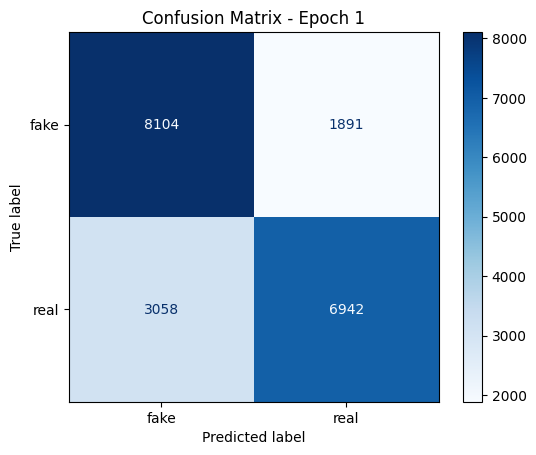


Epoch [2/5]
Train Accuracy: 74.72%
Valid Accuracy: 76.20%
Test Accuracy:  76.77%


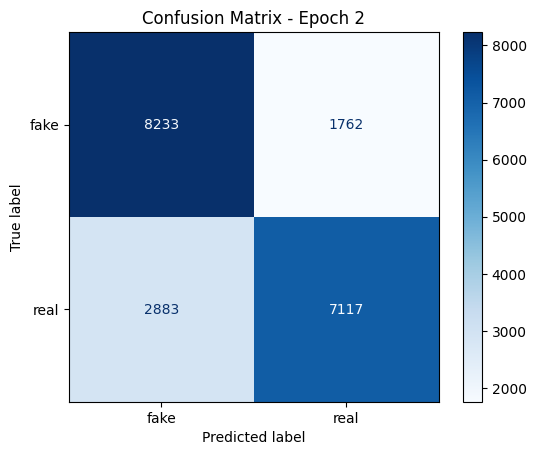


Epoch [3/5]
Train Accuracy: 75.52%
Valid Accuracy: 77.03%
Test Accuracy:  77.47%


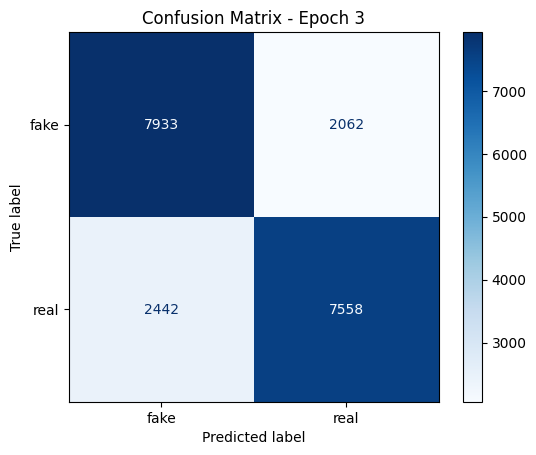


Epoch [4/5]
Train Accuracy: 75.69%
Valid Accuracy: 77.23%
Test Accuracy:  77.64%


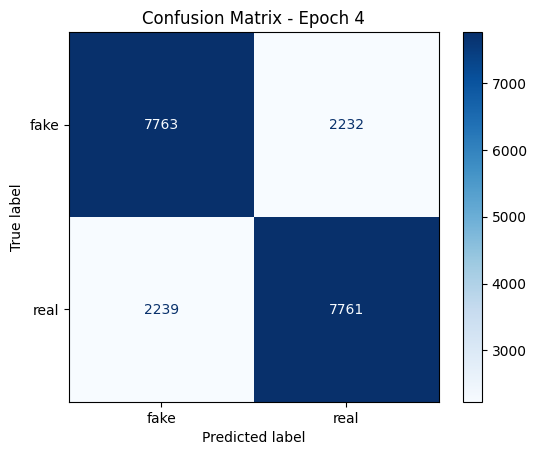


Epoch [5/5]
Train Accuracy: 76.08%
Valid Accuracy: 77.42%
Test Accuracy:  77.87%


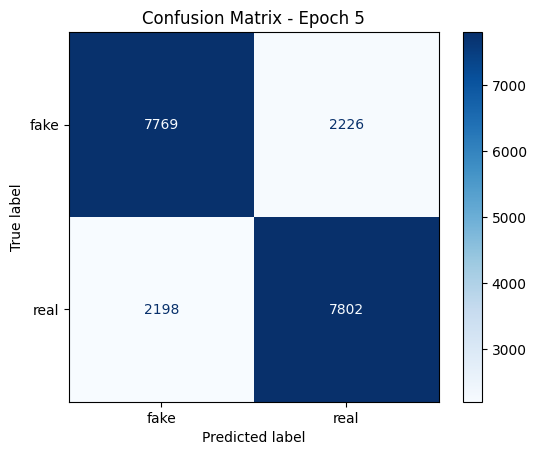


Model saved as deepfake_resnet18.pth


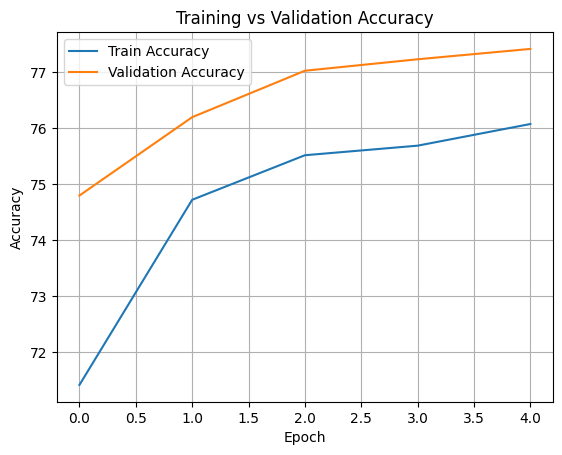

In [25]:
num_epochs = 5
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return 100 * correct / total, all_preds, all_labels

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    val_acc, _, _ = evaluate(valid_loader)
    test_acc, test_preds, test_labels = evaluate(test_loader)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Valid Accuracy: {val_acc:.2f}%")
    print(f"Test Accuracy:  {test_acc:.2f}%")

    # Confusion matrix for test
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.show()

    scheduler.step()

# Save model
torch.save(model.state_dict(), "deepfake_resnet18.pth")
print("\nModel saved as deepfake_resnet18.pth")

# Accuracy plot
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [3]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# Load ResNet18 with pretrained weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze all layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake


In [4]:
### 🔍 Load Trained Model and Make Predictions


In [5]:
# Cell 1: Imports (if not already available)
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from PIL import Image


In [6]:
# Cell 2: Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


In [8]:
import os
print(os.getcwd())


D:\deepfake proj


In [9]:
os.chdir(r"D:\deepfake proj")


In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final layer for 2 classes (real, fake)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Load the saved weights
model.load_state_dict(torch.load("deepfake_resnet18.pth", map_location=torch.device('cpu')))

# Set model to eval mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Initialize the model architecture exactly as you did during training
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze pretrained layers (if you did that before)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification (2 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Step 2: Load the saved state dict (weights)
state_dict = torch.load("deepfake_resnet18.pth")  # Your saved weights file
model.load_state_dict(state_dict)

# Step 3: Move model to device and set to eval mode
model = model.to(device)
model.eval()

# Now you can do inference with your model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image
import os

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Initialize model architecture
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# 2. Load saved weights
state_dict = torch.load("deepfake_resnet18.pth")
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# 3. Define image transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# 4. Define class labels
class_names = ['fake', 'real']  # Use the same order as in training

# 5. Function to predict one image
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        return class_names[preds.item()]

# 6. Run predictions on test folder
test_dir = r"C:\Users\acer\Downloads\archive (9)\real_vs_fake\real-vs-fake\test"

for label in ['real', 'fake']:
    folder_path = os.path.join(test_dir, label)
    print(f"Predictions for {label} images:")
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        pred = predict_image(img_path)
        print(f"Image: {img_file} -> Predicted: {pred}")
    print("\n")


Predictions for real images:
Image: 00001.jpg -> Predicted: real
Image: 00004.jpg -> Predicted: fake
Image: 00007.jpg -> Predicted: real
Image: 00016.jpg -> Predicted: fake
Image: 00023.jpg -> Predicted: fake
Image: 00025.jpg -> Predicted: real
Image: 00028.jpg -> Predicted: real
Image: 00032.jpg -> Predicted: real
Image: 00045.jpg -> Predicted: real
Image: 00053.jpg -> Predicted: real
Image: 00056.jpg -> Predicted: real
Image: 00063.jpg -> Predicted: real
Image: 00088.jpg -> Predicted: real
Image: 00093.jpg -> Predicted: real
Image: 00099.jpg -> Predicted: real
Image: 00104.jpg -> Predicted: real
Image: 00113.jpg -> Predicted: fake
Image: 00114.jpg -> Predicted: real
Image: 00119.jpg -> Predicted: real
Image: 00127.jpg -> Predicted: real
Image: 00132.jpg -> Predicted: real
Image: 00133.jpg -> Predicted: fake
Image: 00136.jpg -> Predicted: real
Image: 00141.jpg -> Predicted: fake
Image: 00142.jpg -> Predicted: real
Image: 00144.jpg -> Predicted: real
Image: 00152.jpg -> Predicted: real

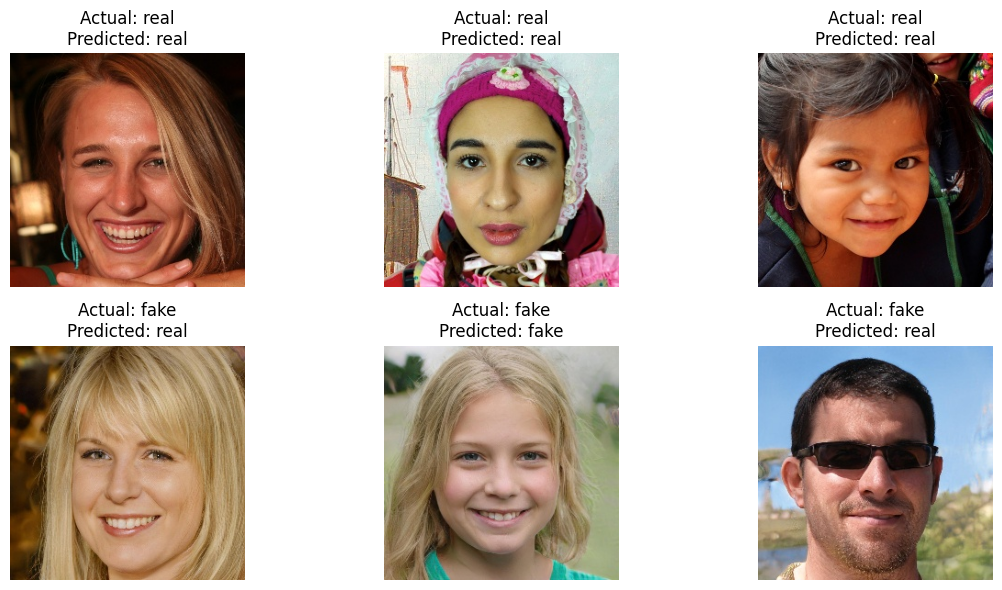

In [17]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch

# Make sure your model is in eval mode and on the right device
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = ['fake', 'real']

# Path to test dataset folder
test_path = r"C:\Users\acer\Downloads\archive (9)\real_vs_fake\real-vs-fake\test"

# Function to predict image label
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    input_img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_img)
        _, pred = torch.max(outputs, 1)
    return pred.item(), img

# Plot a few images from each category
num_images_per_class = 3

plt.figure(figsize=(12, 6))

idx = 1
for label_folder in ['real', 'fake']:
    folder_path = os.path.join(test_path, label_folder)
    images = os.listdir(folder_path)[:num_images_per_class]  # get first few images

    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        pred_label, img = predict_image(img_path)

        plt.subplot(2, num_images_per_class, idx)
        plt.imshow(img)
        plt.axis('off')
        actual_label = label_folder
        predicted_label = class_names[pred_label]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        idx += 1

plt.tight_layout()
plt.show()
